In [1]:
import pandas as pd
import numpy as np
data = pd.read_parquet("../data/albania_res.parquet")

In [2]:
data.index = pd.to_datetime(data.index, utc="UTC")

In [3]:
from mlpforecast.data.transform import DatasetObjective
from sklearn.preprocessing import MinMaxScaler, RobustScaler,SplineTransformer,PowerTransformer


data_params = {
    "target_series": ["NetLoad"],
    "unknown_features": [],
    "calendar_variables": ["HOUR", "Session"],
    "known_calendar_features": ["HOUR-cosin", "Session-cosin"],
    "known_continuous_features": [
        "NetLoad_lag_48",
        "NetLoad_lag_336",
        "Temperature"
    ],
    "input_scaler": PowerTransformer(),
    "target_scaler": PowerTransformer(),
    "lags": [1, 7],
    "windows": [],
    "window_funcs": ["mean"],
    "period": "30min",
    "input_window_size": 96,
    "forecast_horizon": 48,
    "date_column": "timestamp",
}

In [4]:
ds = DatasetObjective(**data_params)

In [5]:
ds.fit(data.reset_index())
ds.data_pipeline

Pipeline(steps=[('feature_extraction',
                 Pipeline(steps=[('lags_step',
                                  FunctionTransformer(func=<function augment_lags at 0x172ea84a0>,
                                                      kw_args={'date_column': 'timestamp',
                                                               'lags': [48,
                                                                        336],
                                                               'value_column': ['NetLoad']})),
                                 ('dropnan_step',
                                  FunctionTransformer(func=<function DatasetObjective._build_feature_pipeline.<locals>.<lambda> at 0x172f42de0>))])),
                ('scaling',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('feat_scaler',
                                                  Pipeline(steps=[('scaler',
                                                                   PowerTransformer())]),
                                                  ['NetLoad_lag_48',
                                                   'NetLoad_lag_336',
                                                   'Temperature']),
                                                 ('target_scaler',
                                                  Pipeline(steps=[('target_scaler',
                                                                   PowerTransformer())]),
                                                  ['NetLoad'])],
                                   verbose_feature_names_out=False))])

In [6]:
x, y = ds.fit_transform(data.reset_index())

In [7]:
import arviz as az
import matplotlib
import matplotlib.pyplot as plt

az.style.use(["science", "arviz-doc", "tableau-colorblind10"])
nice_fonts = {
    "savefig.bbox": "tight",
    "savefig.pad_inches": 0.05,
    "axes.labelsize": 8,
    "font.size": 8,
    "legend.fontsize": 8,
    "legend.frameon": False,
}
matplotlib.rcParams.update(nice_fonts)
import matplotlib_inline.backend_inline

matplotlib_inline.backend_inline.set_matplotlib_formats(
    "svg", "pdf", "retina"
)  # For export

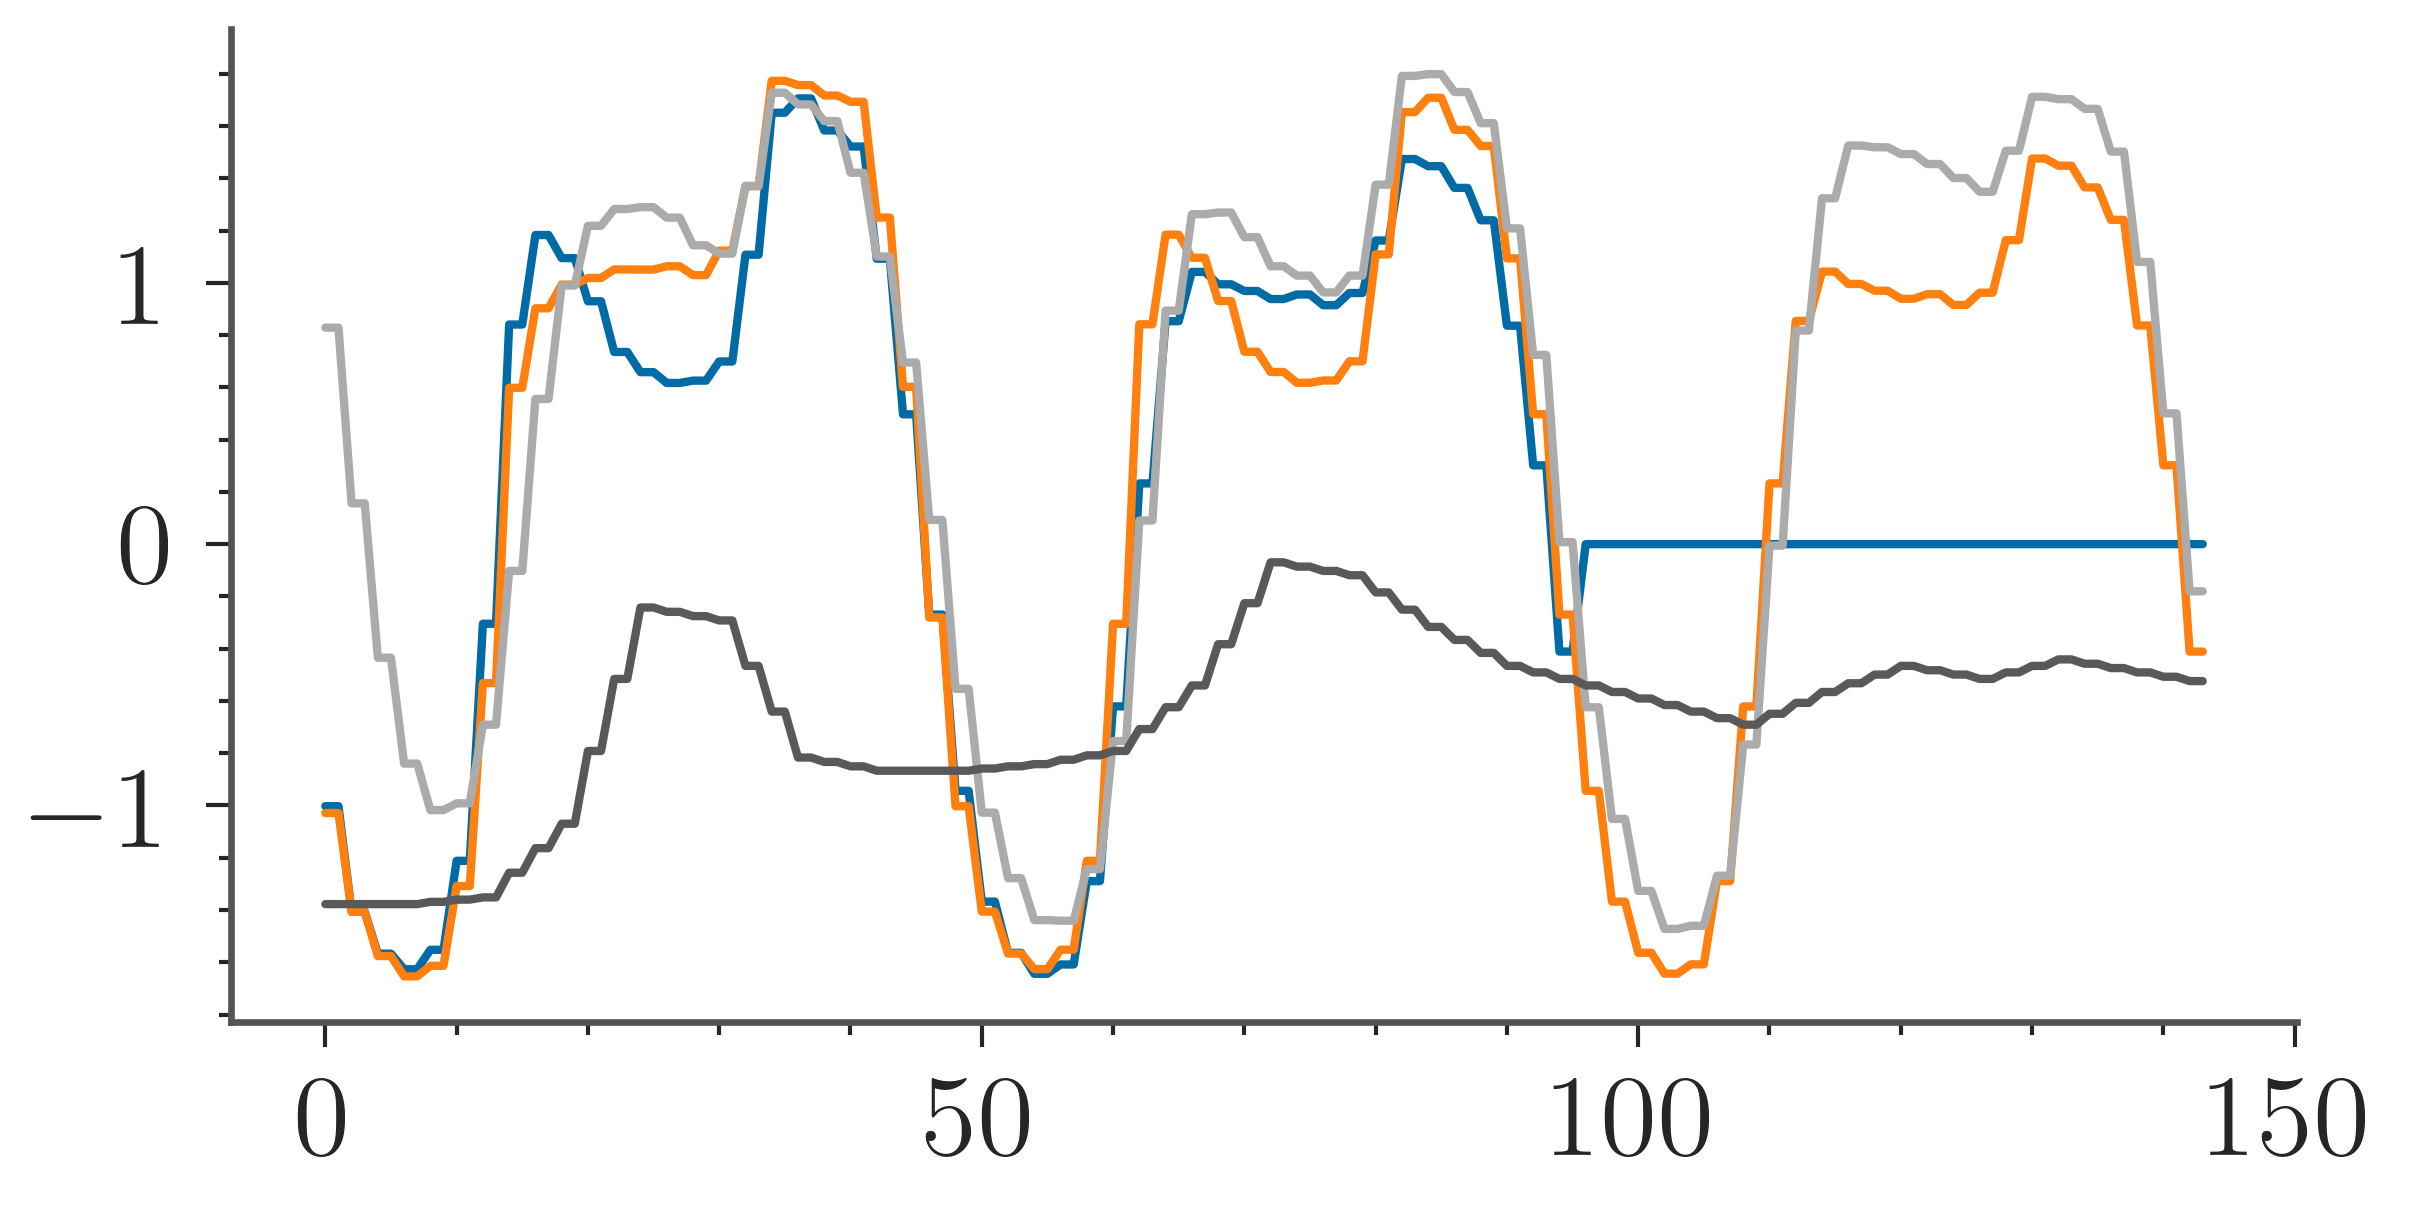

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(4, 2))
ax.plot(x[0, :, :4]);

In [9]:
from mlpforecast.forecaster.mlp import MLPForecast

model_hparams = {
    "data_pipeline": ds,
    "embedding_size": 20,
    "embedding_type": None,
    "combination_type": "addition-comb",
    "hidden_size": 256,
    "num_layers": 2,
    "expansion_factor": 2,
    "residual": True,
    "activation_function": "SiLU",
    "out_activation_function": "Identity",
    "dropout_rate": 0.2,
    "alpha": 0.5,
    "max_epochs": 10,
}

model = MLPForecast(exp_name='test', model_type="MLPF", hparams=model_hparams)

In [10]:
model.fit(data.reset_index()[:20000])

INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:Forecaster:---------------Training started ---------------------------
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at ../checkpoints/Tanesco/default_model/epoch=04.ckpt


┏━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name           ┃ Type               ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ tra_metric_fcn │ MeanAbsoluteError  │      0 │ train │
│ 1 │ val_metric_fcn │ MeanAbsoluteError  │      0 │ train │
│ 2 │ model          │ MLPForecastNetwork │  882 K │ train │
└───┴────────────────┴────────────────────┴────────┴───────┘

Trainable params: 882 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 882 K                                                                                                
Total estimated model params size (MB): 3

INFO:pytorch_lightning.utilities.rank_zero:Restored all states from the checkpoint at ../checkpoints/Tanesco/default_model/epoch=04.ckpt


Output()

INFO:root:training complete after 0.2841269951333137 minutes


In [11]:
x, y = next(iter(model.datamodule.train_dataloader()))

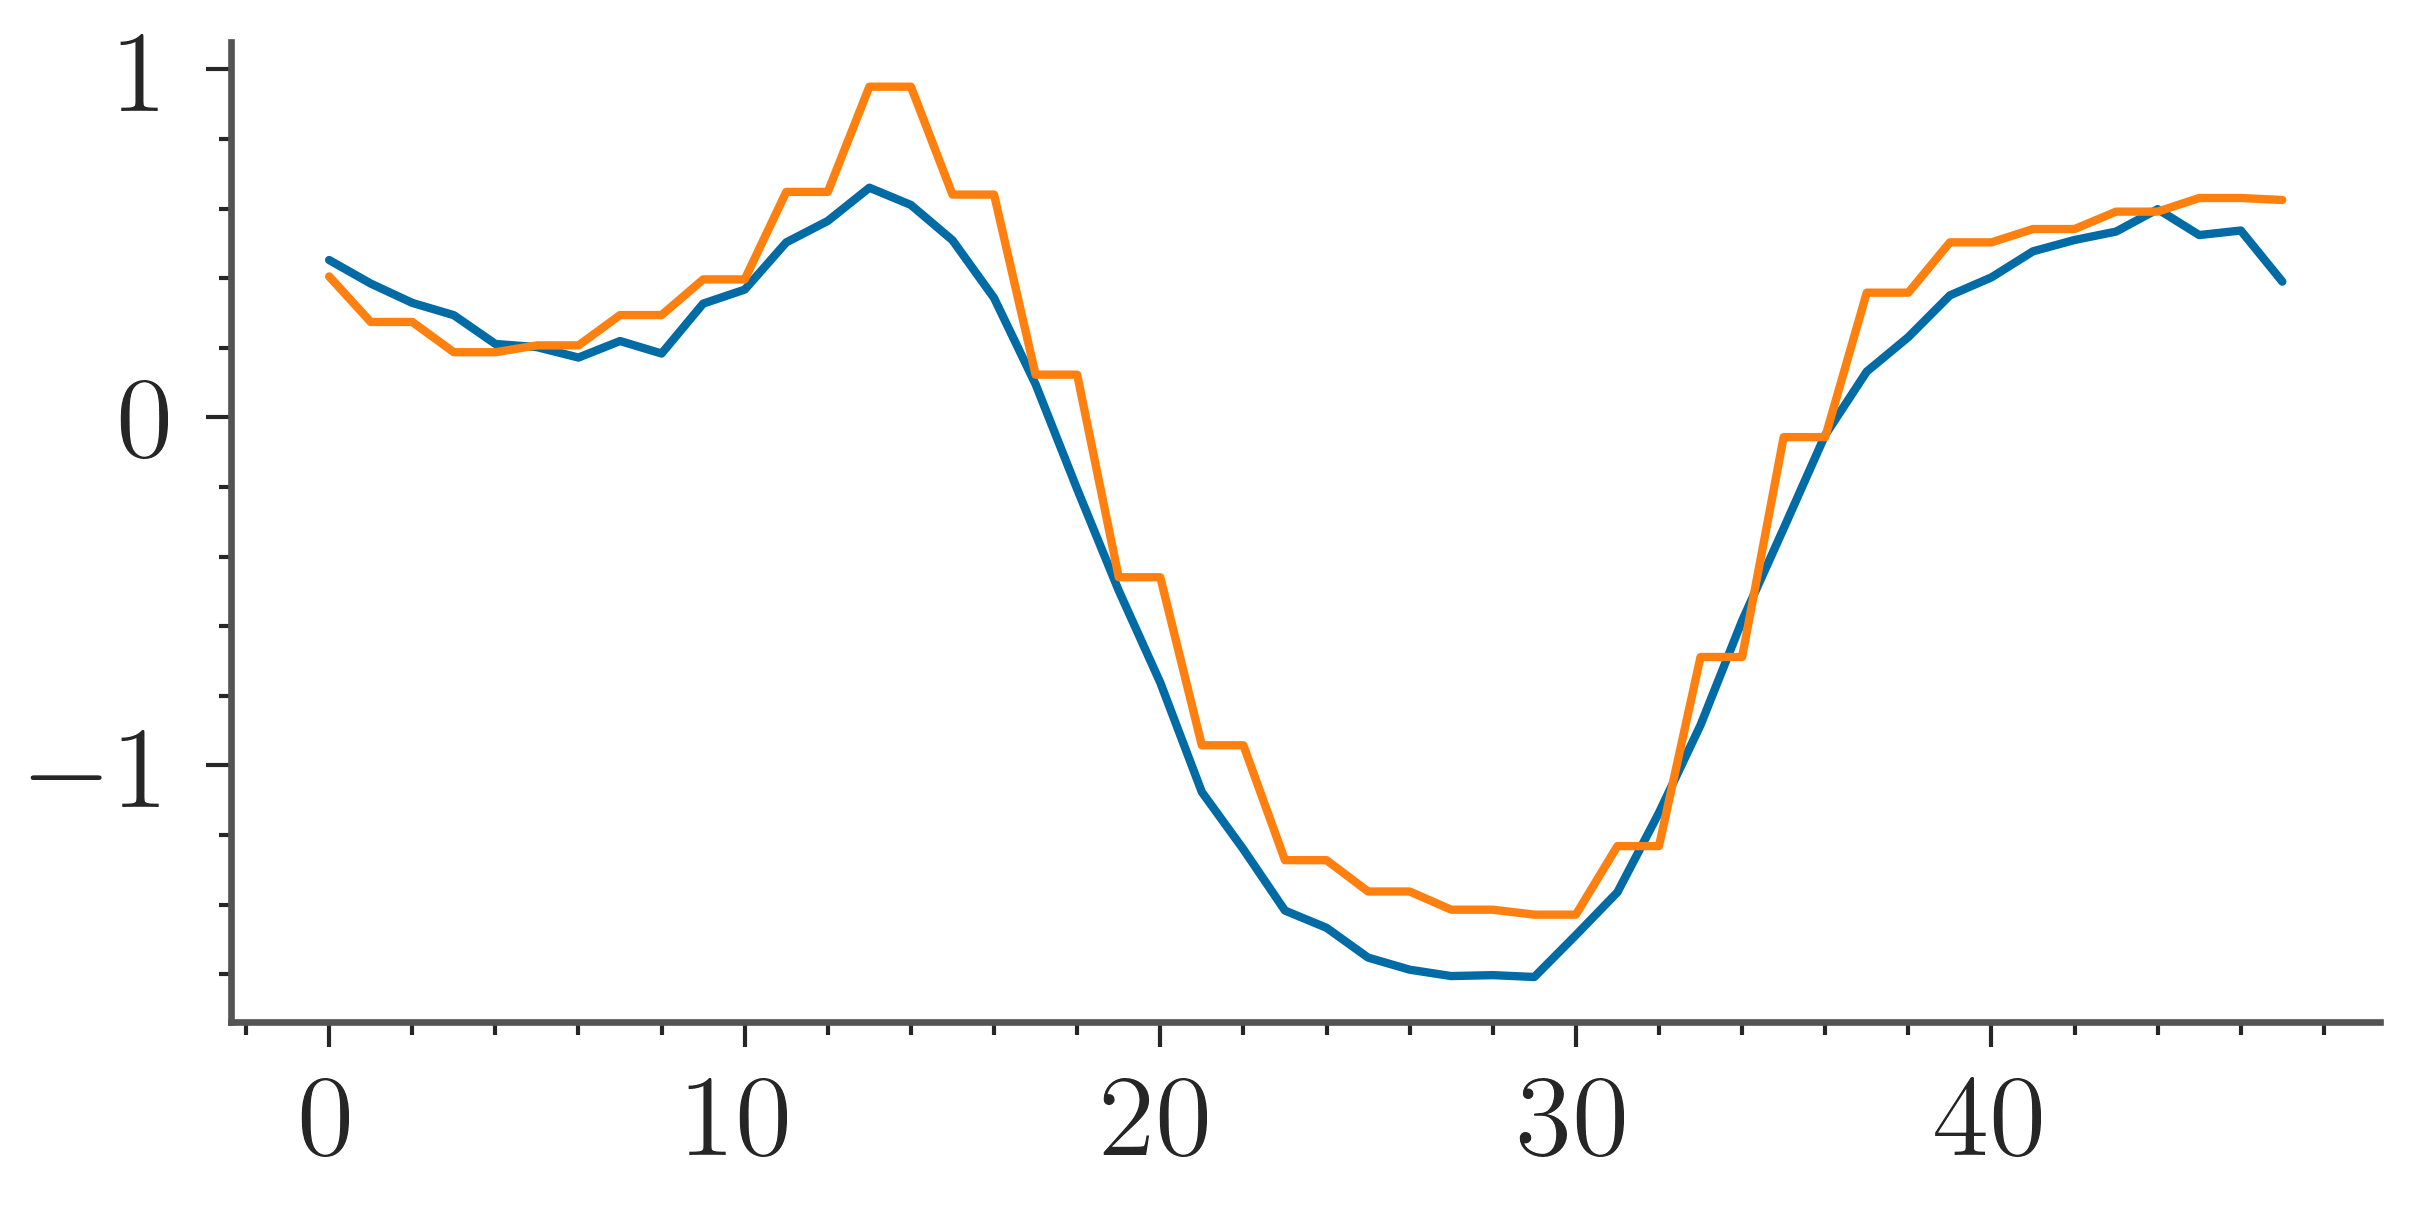

In [12]:
model.model.eval()
pred = model.model.forecast(x)["pred"]
fig, ax = plt.subplots(1, 1, figsize=(4, 2))
ax.plot(pred[0, :, 0])
ax.plot(y[0, :, 0]);

In [16]:
model.model.load_from_checkpoint('../checkpoints/Tanesco/default_model/epoch=04.ckpt')

TypeError: The classmethod `MLPForecastModel.load_from_checkpoint` cannot be called on an instance. Please call it on the class type and make sure the return value is used.

In [13]:
out=model.predict(data.reset_index()[20000:20000+48*7*2])

AttributeError: 'NoneType' object has no attribute 'target_series'

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(9, 2))
from mlpforecast.plot.visual_functions import plot_prediction
ax=plot_prediction(ax, true=out['NetLoad'].values,
                mu=out['NetLoad_forecast'].values)
ax.set_ylim(0, 1500)
ax.set_ylabel('Power (MWh)')
fig.tight_layout(pad=1.08, h_pad=0.5, w_pad=0.5)

In [ ]:
model.metrics.groupby('target')[['MSE', "SMAPE"]].mean()

In [ ]:
from mlpforecast.evaluation.backtester import BacktestingForecast

In [ ]:
backtest = BacktestingForecast(forecast_len=4, 
                    incremental_len = 2,
                    min_train_len=12,
                    n_splits=10,
                    window_type='expanding'
                    )

In [ ]:
model = MLPForecast(hparams=hparams)
pred_df, metric_df=backtest.fit(data.reset_index(), model=model)